In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import pandas as pd
import os
from dotenv import load_dotenv
import time
from collections import Counter
import random
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, precision_score,recall_score,confusion_matrix,classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import InputLayer,Conv2D,MaxPooling2D,MaxPool2D,Flatten,Dense,Dropout
from tensorflow.keras.preprocessing import image as IMG



In [228]:
# with open('image_data_array.pickle','rb') as file:
#     data = pickle.load(file)
    

In [229]:
# X_train, X_test,y_train,y_test = data[0],data[1],data[2],data[3]

# #Split data into train and validation set
# X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,random_state = 17,shuffle =True,test_size =.2)

# y_train_hotcode = keras.utils.to_categorical(y_train)
# y_val_hotcode = keras.utils.to_categorical(y_val)
# y_test_hotcode = keras.utils.to_categorical(y_test)

In [28]:
IMG_SIZE = 150
test_dir = "work_data/test"
val_dir = "work_data/validation"
train_dir = "work_data/train"

In [39]:
IMGgen = IMG.ImageDataGenerator(
        rotation_range=60,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest')

In [40]:
train_ds =IMGgen.flow_from_directory(train_dir, target_size=(IMG_SIZE, IMG_SIZE),batch_size=32)

val_ds = IMGgen.flow_from_directory(val_dir, target_size=(IMG_SIZE, IMG_SIZE),batch_size=16)


test_ds = keras.utils.image_dataset_from_directory(
                            test_dir,
                            label_mode= 'categorical',
                            batch_size=1, 
                            image_size=(IMG_SIZE,IMG_SIZE), 
                            shuffle=False, 
                            seed=None)


# test_ds = IMG.ImageDataGenerator(rescale=1./255).
#                 flow_from_directory(test_dir, target_size=(IMG_SIZE, IMG_SIZE),batch_size=1)

Found 4158 images belonging to 8 classes.
Found 1379 images belonging to 8 classes.
Found 1379 files belonging to 8 classes.


#### Transfer Learning with Xception 

#### Freeze Xception parameter and exclude top layers

In [41]:
Xception_base = keras.applications.Xception(weights="imagenet", 
                                            input_shape=(150, 150, 3),
                                            include_top=False) 

Xception_base.trainable = False

In [32]:
# data_augmentation = keras.Sequential([
#         layers.RandomFlip("horizontal_and_vertical"),
#         layers.RandomRotation(0.1)])

In [42]:
if os.path.exists("Xception_model_directory--.h5") == False:
    

    inputs = keras.Input(shape=(150, 150, 3))

    #x = data_augmentation(inputs)  # Apply random data augmentation
    
    x = keras.applications.xception.preprocess_input(inputs)
    x = Xception_base(x, training=False)
    
    x = Flatten()(x)
#     x = keras.layers.Dense(32)(x)
#     x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
#     x = keras.layers.Dense(32)(x)
#     x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(32)(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(8)(x)
    Xception = keras.Model(inputs, outputs)

    Xception.summary()

    Xception.compile(
        loss='categorical_crossentropy',
        #loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        #optimizer= keras.optimizers.Adam(learning_rate=0.01),
        optimizer = 'Adam',
        metrics=['accuracy'],
    )

    Xception_result = Xception.fit(train_ds,
                             validation_data= val_ds,
                             epochs=30,
                            verbose=1, 
                            callbacks = tf.keras.callbacks.EarlyStopping(patience=5))  # track progress as we fit


    Xception.save("Xception_model_directory.h5")
    with open('Xception_result_directory.pickle','wb')as file:
        pickle.dump(Xception_result, file)

else: 
    Xception = keras.models.load_model('Xception_model_directory.h5')
        
    with open('Xception_result_directory.pickle','rb') as file:
        Xception_result = pickle.load(file)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.truediv_10 (TFOpLam  (None, 150, 150, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_10 (TFOpLa  (None, 150, 150, 3)      0         
 mbda)                                                           
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten_5 (Flatten)         (None, 51200)             0         
                                                                 
 dense_33 (Dense)            (None, 32)                163

/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
Xception= keras.models.load_model('Xception_model_directory.h5')
y_pred = np.argmax(Xception.predict(X_test),axis =1)

In [ ]:
print("accuracy :",accuracy_score(y_test, y_pred))
print('recall :',recall_score(y_test,y_pred,average = 'macro'))
print('precision :', precision_score(y_test,y_pred,average = 'macro'))
print('f1 :', f1_score(y_test,y_pred,average = 'macro'))

####  Train Xception parameters

In [164]:
if os.path.exists('Xception_model_base_trainable.h5') == False:
    Xception_base.trainable = True
    Xception.summary()

    Xception.compile(
        optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    
    Xception_base_trainable_result = Xception.fit(train_ds,
                                                 validation_data= val_ds, 
                                                  epochs=10, 
                                                  verbose=1,
                                                  batch_size =32,
                                                 callbacks = keras.callbacks.EarlyStopping(patience=5) )  # track progress as we fit
    Xception.save("Xception_model_base_trainable.h5")

True

Epoch 1/10
152/152 [==============================] - 645s 4s/step - loss: 0.5728 - accuracy: 0.8093 - val_loss: 0.5666 - val_accuracy: 0.8132
Epoch 2/10
152/152 [==============================] - 621s 4s/step - loss: 0.5105 - accuracy: 0.8204 - val_loss: 0.5434 - val_accuracy: 0.8181
Epoch 3/10
152/152 [==============================] - 646s 4s/step - loss: 0.4748 - accuracy: 0.8352 - val_loss: 0.5285 - val_accuracy: 0.8156
Epoch 4/10
152/152 [==============================] - 634s 4s/step - loss: 0.4545 - accuracy: 0.8418 - val_loss: 0.5037 - val_accuracy: 0.8305
Epoch 5/10
152/152 [==============================] - 639s 4s/step - loss: 0.4070 - accuracy: 0.8570 - val_loss: 0.5259 - val_accuracy: 0.8239
Epoch 6/10
152/152 [==============================] - 634s 4s/step - loss: 0.3811 - accuracy: 0.8685 - val_loss: 0.4790 - val_accuracy: 0.8469
Epoch 7/10
152/152 [==============================] - 572s 4s/step - loss: 0.3762 - accuracy: 0.8706 - val_loss: 0.4798 - val_accuracy: 0.8444

In [175]:
Xception= keras.models.load_model('Xception_model_base_trainable.h5')
y_pred = np.argmax(Xception.predict(X_test),axis =1)
print("accuracy :",accuracy_score(y_test, y_pred))
print('recall :',recall_score(y_test,y_pred,average = 'macro'))
print('precision :', precision_score(y_test,y_pred,average = 'macro'))
print('f1 :', f1_score(y_test,y_pred,average = 'macro'))

accuracy : 0.7991228070175439
recall : 0.8679254722227097
precision : 0.80427590054281
f1 : 0.8257771753857203


###  Transfer learning with VGG16

#### Freeze vgg16 parameters and exclude top layers

In [223]:
if os.path.exists("vgg16_model.h5") == False:
    
    vgg16_base = keras.applications.vgg16.VGG16(
                                                include_top= False, 
                                                weights='imagenet', 
                                                input_shape= (150,150,3))

    vgg16_base.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))

    #x = data_augmentation(inputs)  # Apply random data augmentation
    
    x = keras.applications.vgg16.preprocess_input(inputs)
    x = vgg16_base(x, training=False)

    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(16)(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    x = keras.layers.Dense(32)(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(8)(x)
    vgg16 = keras.Model(inputs, outputs)

    vgg16.summary()

    vgg16.compile(
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits= True),
        optimizer = 'Adam',
        metrics=['accuracy'],
    )

    vgg16_result = Xception.fit(train_ds,
                                validation_data= val_ds,
                                epochs=30, 
                                verbose=1,
                                batch_size =32,
                                callbacks = keras.callbacks.EarlyStopping(patience=5)) 

    vgg16.save("vgg16_model.h5")
    
#     with open('vgg16_result.pickle','wb')as file:
#         pickle.dump(vgg16_result, file)

else: 
    vgg16 = keras.models.load_model('vgg16_model.h5')
        
#     with open('vgg16_result.pickle','rb') as file:
#         vgg16_result = pickle.load(file)

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 tf.__operators__.getitem_7   (None, 150, 150, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_7 (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_18  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                          

In [225]:
vgg16 = keras.models.load_model('vgg16_model.h5')

#y_pred = np.argmax(vgg16.predict(test_ds),axis =1)
y_pred = np.argmax(vgg16.predict(X_test),axis=1)



print("accuracy :",accuracy_score(y_test, y_pred))
print('recall :',recall_score(y_test,y_pred,average = 'macro'))
print('precision :', precision_score(y_test,y_pred,average = 'macro'))
print('f1 :', f1_score(y_test,y_pred,average = 'macro'))

accuracy : 0.1412280701754386
recall : 0.06944446762349799
precision : 0.07099810169735571
f1 : 0.06861966245413754


#### Train VGG16 parameters

In [231]:
if os.path.exists('vgg16_model_trainable.h5') == False:
    vgg16_base.trainable = True
    vgg16.summary()

    vgg16.compile(
                optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy']
                )
    
    vgg16_result = vgg16.fit(train_ds, 
                         validation_data = val_ds,
                         epochs = 100,
                         callbacks = keras.callbacks.EarlyStopping(patience=5),
                         verbose =1,
                         batch_size = 32)
    vgg16.save('vgg16_model_trainable.h5')

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 tf.__operators__.getitem_7   (None, 150, 150, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_7 (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_18  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                          

KeyboardInterrupt: 

In [ ]:
vgg16 = keras.models.load_model('vgg16_model_trainable.h5')
y_pred = np.argmax(vgg16.predict(X_test),axis=1)
print("accuracy :",accuracy_score(y_test, y_pred))
print('recall :',recall_score(y_test,y_pred,average = 'macro'))
print('precision :', precision_score(y_test,y_pred,average = 'macro'))
print('f1 :', f1_score(y_test,y_pred,average = 'macro'))

#### Test model result

(-0.5, 149.5, 149.5, -0.5)

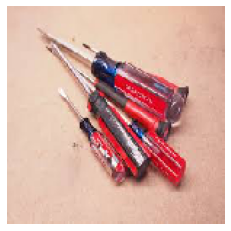

In [89]:
pred_index =1500
plt.imshow(X_test[pred_index]/np.max(X_test[pred_index]))
plt.axis('off')

In [90]:
pre_array = Xception.predict(tf.expand_dims(X_test[pred_index],0))
int_category_map.get(pre_array.argmax())

'Screw Driver'